# 10：データ拡張（Data Augmentation）


---
## 目的
PyTorchを用いてMNIST Datasetに対する文字認識を行う．

また，データ拡張（Data Augmentation）による効果を確認する．


## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**


## モジュールのインポート
はじめに必要なモジュールをインポートする．

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`GPU availability: True`と表示されれば，GPUを使用した計算をPyTorchで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．


In [13]:
# モジュールのインポート
import os
from time import time
import numpy as np
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import torchsummary

import gzip
from random import randint

import matplotlib.pyplot as plt

# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## データセットのダウンロードと読み込みと学習サンプルの削減


まずはじめに，`wget`コマンドを使用して，MNISTデータセットをダウンロードします．

In [2]:
!wget -q http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -O train-images-idx3-ubyte.gz
!wget -q http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -O train-labels-idx1-ubyte.gz
!wget -q http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -O t10k-images-idx3-ubyte.gz
!wget -q http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -O t10k-labels-idx1-ubyte.gz

次に，ダウンロードしたファイルからデータを読み込みます．詳細は前回までのプログラムを確認してください．

今回は2次元の画像データとしてMNISTデータセットを扱うため，
データを`(チャンネル, 縦，横)`の形に並べ替えます．

In [6]:
# load images
with gzip.open('train-images-idx3-ubyte.gz', 'rb') as f:
    x_train = np.frombuffer(f.read(), np.uint8, offset=16)
x_train = x_train.reshape(-1, 784)

with gzip.open('t10k-images-idx3-ubyte.gz', 'rb') as f:
    x_test = np.frombuffer(f.read(), np.uint8, offset=16)
x_test = x_test.reshape(-1, 784)

with gzip.open('train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)

with gzip.open('t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)

x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 1, 28, 28) (60000,)
(10000, 1, 28, 28) (10000,)


## ネットワークモデルの定義
畳み込みニューラルネットワークを定義します．

ここでは，畳み込み層２層，全結合層３層から構成されるネットワークとします．

１層目の畳み込み層は入力チャンネル数が１，出力する特徴マップ数が16，畳み込むフィルタサイズが3x3です．２層目の畳み込み層は入力チャネル数が16．出力する特徴マップ数が32，畳み込むフィルタサイズは同じく3x3です．１つ目の全結合層は入力ユニット数は不定とし，出力は1024としています．次の全結合層入力，出力共に1024，出力層は入力が1024，出力が10です．これらの各層の構成を`__init__`関数で定義します．

次に，`forward`関数では，定義した層を接続して処理するように記述します．`forward`関数の引数xは入力データです．それを`__init__`関数で定義したconv1に与え，その出力を活性化関数であるrelu関数に与えます．そして，その出力をmax_pooling_2dに与えて，プーリング処理結果をhとして出力します．hはconv2に与えられて畳み込み処理とプーリング処理を行います．そして，出力hをl1に与えて全結合層の処理を行います．最終的にl3の全結合層の処理を行った出力hを戻り値としています．

In [36]:
class CNN(nn.Module):
    def __init__(self, n_channels=1, filter_size=3, num_kernel=64, hidden_size=128):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, num_kernel, kernel_size=filter_size, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.l1 = nn.Linear(int(28/2) * int(28/2) * num_kernel, hidden_size)
        self.l2 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        h = self.relu(self.conv(x))
        h = self.pool(h)
        h = h.view(h.size()[0], -1)
        h = self.relu(self.l1(h))
        h = self.l2(h)
        return h

## Data Augmentationの準備

学習に使用する画像データに変換やノイズを加えるための関数を準備します．
ここでは，ガウシアンノイズをランダムに適用する関数を作成します．

In [28]:
def data_augmentation(input_image):
    bs, ch, h, w = input_image.shape
    dst_image = input_image.copy()
    for batch_index in range(bs):
        augmentation_index = np.random.randint(0, 4, 1)[0]
        if augmentation_index == 0:    # agumentationなし
            continue
        else:  # ガウシアンノイズ
            noise = input_image[batch_index] + np.random.normal(0, 50, (1, 28, 28))
            noise = np.clip(noise, 0, 255)
            dst_image[batch_index, :] = noise
    return dst_image

Data Augmentationを適用した結果を確認します．
この結果を見ると，ランダムに画像が変換されていることが確認できます．

<Figure size 432x288 with 0 Axes>

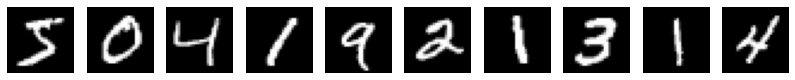

<Figure size 432x288 with 0 Axes>

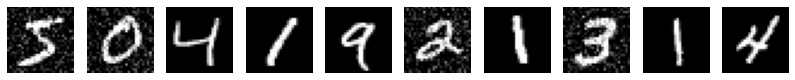

In [30]:
image = x_train[0:10].copy()
aug_image = data_augmentation(image.astype(np.float32))

# 元画像
plt.clf()
fig = plt.figure(figsize=(14, 1.4))
for i in range(image.shape[0]):
    ax = fig.add_subplot(1, 10, i + 1)
    img = image[i].transpose(1, 2, 0)
    plt.imshow(img.astype(np.uint8)[:, :, 0], cmap=plt.cm.gray)
    ax.set_axis_off()
plt.show()


# Data Augmentationを適用した画像
plt.clf()
fig = plt.figure(figsize=(14, 1.4))
for i in range(image.shape[0]):
    ax = fig.add_subplot(1, 10, i + 1)
    img = aug_image[i].transpose(1, 2, 0)
    plt.imshow(img.astype(np.uint8)[:, :, 0], cmap=plt.cm.gray)
    ax.set_axis_off()
plt.show()

## ネットワークの作成
上のプログラムで定義したネットワークを作成します．

CNNクラスを呼び出して，ネットワークモデルを定義します． また，GPUを使う場合（use_cuda == True）には，ネットワークモデルをGPUメモリ上に配置します． これにより，GPUを用いた演算が可能となります．

学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します． また，学習率を0.01，モーメンタムを0.9として引数に与えます．

最後に，定義したネットワークの詳細情報を`torchsummary.summary()`関数を用いて表示します．


In [41]:
model = CNN()
if use_cuda:
    model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# モデルの情報を表示
torchsummary.summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Linear-4                  [-1, 128]       1,605,760
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,607,690
Trainable params: 1,607,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.86
Params size (MB): 6.13
Estimated Total Size (MB): 7.00
----------------------------------------------------------------


## 学習
読み込んだMNISTデータセットと作成したネットワークを用いて，学習を行います．

1回の誤差を算出するデータ数（ミニバッチサイズ）を64，学習エポック数を10とします．

次にデータローダーを定義します．
データローダーでは，上で読み込んだデータセット（`train_data`）を用いて，for文で指定したミニバッチサイズでデータを読み込むオブジェクトを作成します．
この時，`shuffle=True`と設定することで，読み込むデータを毎回ランダムに指定します．

次に，誤差関数を設定します．
今回は，分類問題をあつかうため，クロスエントロピー誤差を計算するための`CrossEntropyLoss`を`criterion`として定義します．

学習を開始します．

各更新において，学習用データと教師データをそれぞれ`image`と`label`とします．
学習モデルにimageを与えて各クラスの確率yを取得します．
各クラスの確率yと教師ラベルtとの誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [42]:
# ミニバッチサイズ・エポック数の設定
batch_size = 100
epoch_num = 10
num_train_data = x_train.shape[0]
n_iter = num_train_data / batch_size

# 誤差関数の設定
criterion = nn.CrossEntropyLoss()
if use_cuda:
    criterion.cuda()

# ネットワークを学習モードへ変更
model.train()

iteration = 1
start = time()
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0
    
    perm = np.random.permutation(num_train_data)
    for i in range(0, num_train_data, batch_size):
        x_batch = x_train[perm[i:i+batch_size]]
        y_batch = y_train[perm[i:i+batch_size]]

        x_batch = data_augmentation(x_batch)

        x_batch = torch.from_numpy(x_batch).type(torch.float32)
        y_batch = torch.from_numpy(y_batch).type(torch.int64)

        if use_cuda:
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

        y = model(x_batch)

        loss = criterion(y, y_batch)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == y_batch)
        
    print("epoch: {}, mean loss: {}, mean accuracy: {}, elapsed_time :{}".format(epoch,
                                                                                 sum_loss / n_iter,
                                                                                 count.item() / num_train_data,
                                                                                 time() - start))

epoch: 1, mean loss: 10.867902806003888, mean accuracy: 0.18516666666666667, elapsed_time :5.442876100540161
epoch: 2, mean loss: 1.8929499832789103, mean accuracy: 0.2825, elapsed_time :10.850626945495605
epoch: 3, mean loss: 1.8566496906677883, mean accuracy: 0.2945333333333333, elapsed_time :16.234654426574707
epoch: 4, mean loss: 1.8427191378672918, mean accuracy: 0.298, elapsed_time :21.566840887069702
epoch: 5, mean loss: 1.8344178547461827, mean accuracy: 0.30328333333333335, elapsed_time :26.86689305305481
epoch: 6, mean loss: 1.830973318417867, mean accuracy: 0.3034833333333333, elapsed_time :32.2159321308136
epoch: 7, mean loss: 1.8299035678307216, mean accuracy: 0.30316666666666664, elapsed_time :37.58416938781738
epoch: 8, mean loss: 1.831110797127088, mean accuracy: 0.30361666666666665, elapsed_time :42.87386083602905
epoch: 9, mean loss: 1.8304104844729105, mean accuracy: 0.30165, elapsed_time :48.27731466293335
epoch: 10, mean loss: 1.8246128670374553, mean accuracy: 0.3

## テスト
学習したネットワークモデルを用いて評価を行います．

In [43]:
# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
num_test_data = x_test.shape[0]

# 勾配計算なしで順伝播計算を行うためのフラグ
with torch.no_grad():
    for i in range(num_test_data):
        x = np.array([x_test[i]], dtype=np.float32)
        t = y_test[i]

        x = torch.from_numpy(x).type(torch.float32)

        if use_cuda:
            x = x.cuda()

        y = model.forward(x)
        pred = torch.argmax(y)
        
        if pred == t:
            count += 1

print("test accuracy: {}".format(count / num_test_data))

test accuracy: 0.8678


## 課題
1. ネットワーク構造を変えて実験しましょう． 
     * まず，1層目の畳み込み層のフィルタ数を32にしましょう．また，2層目の畳み込み層のフィルタ数を64にしましょう．
    * 次に，中間層のユニット数を2048にしましょう．
   


2. 最適化の方法をAdamに変えて実験しましょう．



3. エポック数やミニバッチサイズを変えて実験しましょう．
    * まず，ミニバッチサイズを128にしましょう．
    * 次に，エポック数を50にしましょう．